# Kinematics of robotic arms with Denavit-Hartenberg framework


This lab session concerns robot kinematics. Our focus will be on robotic manipulators, commonly called robot arms. Like the previous weeks, we will run your algorithm on a virtual arm, simulated with pybullet. However, except for the Jupyer Notebook format, this lab session is completely different from those on sensor interpretation. The associated theory just concerns the part "modeling with basis transformation matrices", and its application to robot arms, in the Lecture on Kinematics.

This notebook assumes that you have python3, matplotlib, pybullet and numpy installed. 
You should already have downloaded the figure folder and the urdf folder, and possibly insalled Pybullet, for the homework.

- Exercise 1 is an introductory exercise to get familiar with the DH framework
- Exercise 2 performs inverse kinematics, using the velocity-based apporach as explained in the lecture 
- Exercise 3 shows the power of the DH framework on a multi-body 3D robot arm, where a geometric reasoning would get too cumbersome.

You can also check out the optional questions and additional exercises, but these are mainly meant for training at home.

In [36]:
%matplotlib inline
import pybullet as p
import time
import pybullet_data
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

#import seaborn # optional / improves graphics of pylab plots

## Exercise 1: Comparing geometric vs. DH modeling on planar manipulator

The Denavit-Hartenberg framework (DH) uses basis transformation matrices to obtain a systematic modeling of robot manipuators. It is useful for computer-based modeling of manipulators with many segments, and especially in 3 dimensions, where a manual description of the geometric arrangement becomes difficult. For few segments and in 2 dimensions, a manual geometric description remains reasonably easy. The purpose of this first exercise is to familiarize yourself with the DH framework, relating it to your geometric description, on a simple manipulator.

Consider the following 3-segmented planar robot manipulator, with L1=6, L2=4, L3=2 (in meter). For any values of the joint angles $\theta_1$, $\theta_2$, $\theta_3$, we can compute the end-effector position from geometric properties, using trigonometry. We can also use the DH framework. Finally, we can test on a real robot (here replaced by a pybullet simulation).

![3R planar](./figs/figs.001.jpeg)


### A. Geometric modeling

**Question/exercise**  Derive the position of the end-effector, as a function of the joint angles, "by hand" using geometry/trigonometry. Implement your analytical solution as a function to be used later with explicit values.

In [37]:
def geometric_planar(theta1, theta2, theta3):
    # theta should be a vector with the joint angles
    # implement your analytical solution here (using trigonometry)
    
    # lengths
    L1=6
    L2=4
    L3=2

    pos_x = L1*np.cos(theta1) + L2*np.cos(theta1+ theta2) + L3*np.cos(theta1+ theta2 + theta3)
    pos_y = L1*np.sin(theta1) + L2*np.sin(theta1+ theta2) + L3*np.sin(theta1+ theta2 + theta3)

    
    
    return pos_x, pos_y

### B. DH modeling

**Question/exercise**  Implement the DH modeling to compute the end-effector position as a function of the joint angles.

*Reminder*: 
The DH framework in N dimensions uses (N+1)x(N+1) matrices to represent the end-effector situation as a translation and rotation with respect to a reference coordinate frame$_0$, as follows:

\begin{equation}
g = \begin{bmatrix} 
Rotation_{N x N} & Translation_{Nx1} \\
zeros_{1 x N} & 1 
\end{bmatrix}
\end{equation}

The advantage is that $g=g_{0,4}$ the transformation from coordinate frame $0$ to coordinate frame $4$ can be obtained by just multiplying the consecutive elementary transformations, from coordinate frame $0$ to $1$, then from $1$ to $2$, and so on:

\begin{equation}
g_{0,4} = g_{0,1} * g_{1,2} * g_{2,3} * g_{3,4}.
\end{equation}

The important simplification is that for writing down for instance $T_{1,2}$, you only need to check how frame 2 is positioned **in the coordinates of frame 1**, thus here translated along $x_1$ then turned by $\theta_2$.

For planar motion (N=2), the transformation matrix which takes the reference frame at $j$, **first** translates it by the vector $(p_x, p_y)$ (with x,y components according to the coordinate frame $j$), **then** rotates it by an angle $\alpha$, has the explicit form:
\begin{equation}
\mathrm{g_{j,k}}(\alpha,p) = 
\begin{bmatrix} 
\cos(\alpha) & -\sin(\alpha) & p_x \\
\sin(\alpha) & \cos(\alpha) & p_y \\
0 & 0 & 1 
\end{bmatrix} \;\; .
\end{equation}



In [58]:
def DH_planar(theta1, theta2, theta3):
    # lengths
    L1=6
    L2=4
    L3=2

    #HERE THE SOLUTION
    
    # some helper functions
    s1 = np.sin(theta1)
    c1 = np.cos(theta1)
    s2 = np.sin(theta2)
    c2 = np.cos(theta2)    
    s3 = np.sin(theta3)
    c3 = np.cos(theta3)       
    
    g01 = np.array([[c1, -s1, 0],
                  [s1, c1,  0],
                  [0,0,1]])
    g12 = np.array([[c2, -s2, L1],
                  [s2, c2,  0],
                  [0,0,1]])
    g23 = np.array([[c3,-s3,L2],
                    [s3,c3,0],
                    [0,0,0]])
    g34 = np.array([[1,0,L3],
                    [0,1,0],
                    [0,0,1]])
    
    g = g01 @ g12 @ g23 @ g34

    pos_x = g[0,2]
    pos_y = g[1,2]

    return pos_x, pos_y

### C.  Validating the solution

Compare the solutions obtained with your two functions, and the one obtained with Pybullet.

**Question/exercise** Run the code below and check that you draw the same picture with all three models. If not, correct your code and make sure to understand how things must be modeled in DH on this planar example.

In [55]:
# defining the sequence of angle values (some random shape)

theta1seq = np.pi*np.array([0  , -0.1 , -0.2 , -0.1 , 0 ,   0.3 , 1/7, 1/7, 1/6, 0  , 1/6 , 1/6, 0.3/(np.pi) ])
theta2seq = np.pi*np.array([0.5, 0.5  , 0.5  , 0.5  , 0.5 , -0.4 , 0,  0, 0,   1/6,  0 , -1/4, -0.6/(np.pi) ])
theta3seq = np.pi*np.array([0  , 0.5 ,  1 ,    1.3 , 1.6,  0.1 ,   0,  -3/5, 1/6, 1.3, 1.5 , 0, 0 ])

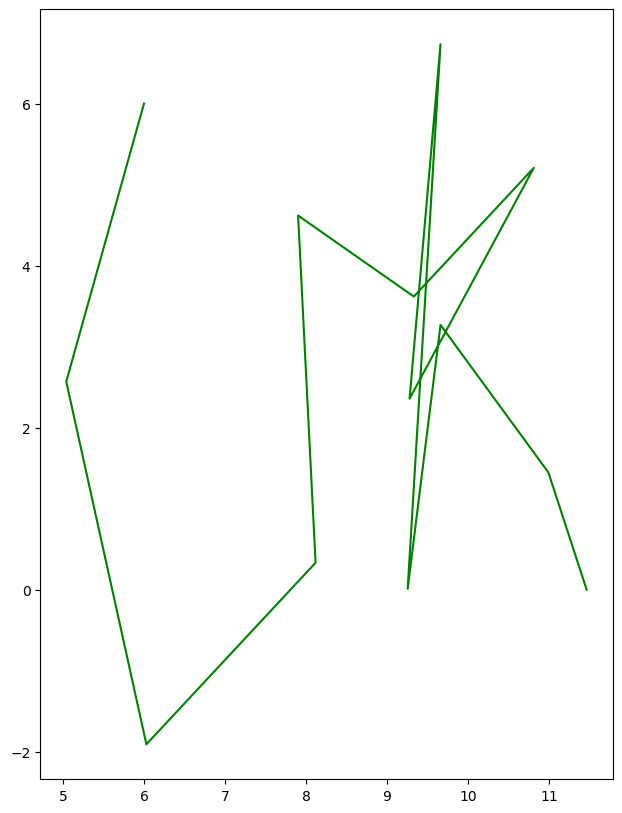

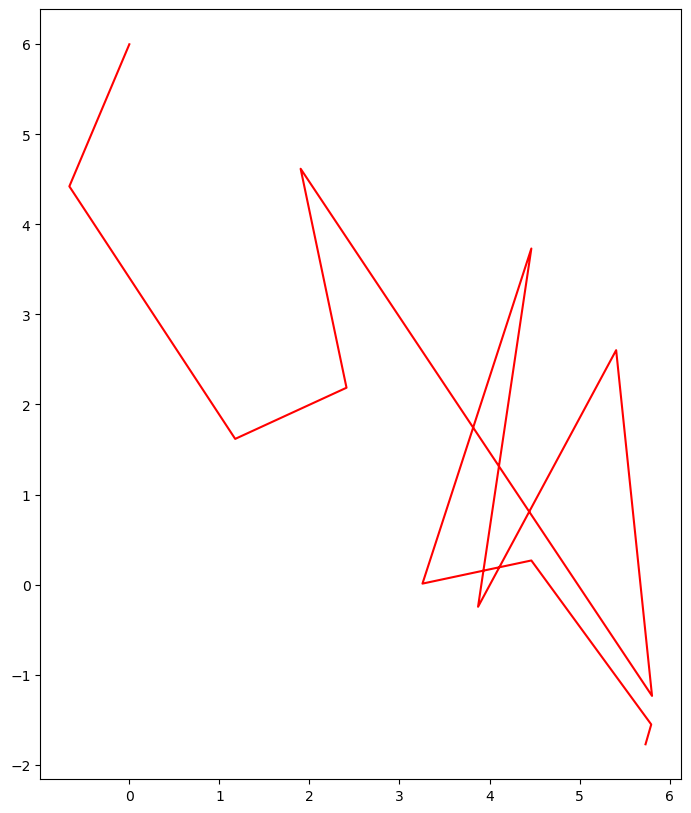

In [59]:
# Let us start with the geometric model    
x = []
y = []
for i in range(len(theta1seq)):
    x.append(geometric_planar(theta1seq[i], theta2seq[i], theta3seq[i])[0])
    y.append(geometric_planar(theta1seq[i], theta2seq[i], theta3seq[i])[1])
fig, axnstd2 = plt.subplots(figsize=(10, 10))
pl.plot(x,y,'g-')
axnstd2.set_aspect("equal")

# Here comes the DH model
x = []
y = []
for i in range(len(theta1seq)):
    x.append(DH_planar(theta1seq[i], theta2seq[i], theta3seq[i])[0])
    y.append(DH_planar(theta1seq[i], theta2seq[i], theta3seq[i])[1])
fig, axnstd = plt.subplots(figsize=(10, 10))
pl.plot(x,y,'r-')
axnstd.set_aspect("equal")

The next cells initialize the pybullet simulation

In [31]:
physicsClient = p.connect(p.DIRECT) #or p.GUI for the graphical version

In [32]:
p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=0, cameraPitch=-89, cameraTargetPosition=[0,0,1.0])
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
p.setGravity(0,0,0)
planeId = p.loadURDF("plane.urdf")
start_pos = [0,0,2.9]
start_orientation = p.getQuaternionFromEuler([0,0,0])

After setup of the pybullet environment we load an URDF-file which describes all the elements of our robot.

In [33]:
robot_id = p.loadURDF("urdf/planar_robot.urdf", start_pos, start_orientation, useFixedBase=True)
numJoints = p.getNumJoints(robot_id) # get the number of joints from the URDF

b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
base_linkb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
link1b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
link2b3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126]:
No inertial data for link, using mass=1, localinertiadiagonal = 1,1,1, identity local inertial frameb3Warning[examples/Importers/ImportURDFDemo/BulletUrdfImporter.cpp,126

Now we can simulate the robot. The function *resetJointState* is used to force the robot into its position. With the function *getLinkState* we can get the state of a link. We have a dummy joint at the end-effector in order to get its state.

In [34]:
x = []
y = []
for i in range(len(theta1seq)):
    jointPoses = (theta1seq[i], theta2seq[i], theta3seq[i])
    for j in range(numJoints-1): # last joint is a dummy joint (fixed end-effector)
        p.resetJointState(robot_id,j,jointPoses[j])
    x.append(p.getLinkState(robot_id,3)[0][0])
    y.append(p.getLinkState(robot_id,3)[0][1])
fig, axnstd = plt.subplots(figsize=(10, 10))
pl.plot(x,y,'b-')
axnstd.set_aspect("equal")

<IPython.core.display.Javascript object>

In [24]:
p.disconnect() # end of exercise

### Brain teasers  (optional)

**Question/exercise** 

(a) What is the workspace of the robot, i.e. the points in the plane accessible by the end-effector ?
(If you want you can explore this in simulation, by exploring all the joint angle values)

(b) Comment on the lengths $L_1, L_2, L_3$ of the links: What could have motivated this choice? If we want to make one link longer, which one(s) should it be?

## Exercise 2: Inverse kinematics with the DH method

During the lectures we have seen that doing inverse kinematics on the basis of specified positions can be a difficult, nonlinear problem; but, doing inverse kinematics on the basis of specified *velocities* becomes easy and linear.

Here we apply this velocity-based approach to the planar robot arm of Exercise 1. The principle is thus to say: 
- we are in a situation with *given* angles $\theta_1, \theta_2, \theta_3$
- from there, a target velocity is specified for the end-effector
- we have to translate this target velocity into velocities $u_i = d\theta_i/dt$ for the joint angles

### A. Setting up the velocity-based inverse kinematics

We start by writing the kinematics as a relation 
\begin{equation*}
A * x = b \tag{1}
\end{equation*}
where $x$ contains the joint velocities $u_i = d\theta_i/dt$ (i=1,2,3) and $b$ contains the target veclotiy of the end-effector ($\frac{d}{dt}pos_x$ and $\frac{d}{dt}p_y$). Thus $A$ will be a 2-by-3 matrix, expressing that there are 2 equations for 3 unknowns, i.e. the linear system is under-specified.

Physically, this under-specification expresses that we have 3 joints, while 2 joints would be enough to displace the end-effector locally both in $x$ and $y$ coordinates. Due to the additional joint, there are several ways to make the end-effector perform a particular movement, and we have to choose one. From a computational standpoint, there are various ways to treat this. To just obtain a solution to $A * x = b$ in python, where $x$ and $b$ do not have the same dimension, you can use the command np.linalg.lstsq(A, b, rcond=None)[0].
(See brain teaser for further thoughts about this.)


**Question/exercise**
- From your Geometric Model of Exercise 1, compute the relation between joint angle velocities and end-effector velocities; express it in the form (1).
- Write a routine which inverts the relation (1) in order to help compute inverse kinematics. Take care about the inputs which it must have. 


In [60]:
def PlanarIK_geom(jointconf,eevel):
    # jointconf contains the current joint configuration
    #  (since the A matrix will depend on it)
    # eevel contains the velocities which we want to achieve on the end effector

    
    # lengths
    L1=6
    L2=4
    L3=2

    #HERE THE SOLUTION

    theta1 = jointconf[0]
    theta2 = jointconf[1]
    theta3 = jointconf[2]

    #pos_x = L1*np.cos(theta1) + L2*np.cos(theta1+ theta2) + L3*np.cos(theta1+ theta2 + theta3)
    #pos_y = L1*np.sin(theta1) + L2*np.sin(theta1+ theta2) + L3*np.sin(theta1+ theta2 + theta3)

    dpxdth1 = -L1*np.sin(theta1) - L2*np.sin(theta1+theta2)- L3*np.sin(theta1+theta2+theta3)
    dpxdth2 = - L2*np.sin(theta1+theta2)- L3*np.sin(theta1+theta2+theta3)
    dpxdth3 = - L3*np.sin(theta1+theta2+theta3)

    dpydth1 = L1*np.cos(theta1) + L2*np.cos(theta1+theta2) + L3*np.cos(theta1+theta2+theta3)
    dpydth2 = L2*np.cos(theta1+theta2) + L3*np.cos(theta1+theta2+theta3)
    dpydth3 = L3*np.cos(theta1+theta2+theta3)
    
    A = np.array([[dpxdth1,dpxdth2 ,dpxdth3],[dpydth1,dpydth2 ,dpydth3]])
    
    uvector = np.linalg.lstsq(A,eevel,rcond=None)[0]

    
    return uvector
    

For more complicated robot arms, the "by-hand" geometric modeling becomes cumbersome, so a more systematic approach uses the DH framework. The velocity-based modeling also takes a systematic form in this DH framework. Indeed, we recall that 
\begin{eqnarray}
\tfrac{d}{dt} g_{0,4} &=& \tfrac{d}{dt}\left( g_{0,1}(\theta_1) * g_{1,2}(\theta_2) * g_{2,3}(\theta_3) * g_{3,4} \right)\\
&=& u_1 \; \frac{dg_{0,1}}{d\theta_1} * g_{1,2}(\theta_2) * g_{2,3}(\theta_3) * g_{3,4} + u_2 \; g_{0,1}(\theta_1) * \frac{dg_{1,2}}{d\theta_2} * g_{2,3}(\theta_3) * g_{3,4} + u_3 \; g_{0,1}(\theta_1) * g_{1,2} * \frac{dg_{2,3}}{d\theta_3} * g_{3,4}
\end{eqnarray}
where the derivative of a basis transformation matrix 
\begin{equation}
\mathrm{g}(\alpha,p) = 
\begin{bmatrix} 
\cos(\alpha) & -\sin(\alpha) & p_x \\
\sin(\alpha) & \cos(\alpha) & p_y \\
0 & 0 & 1 
\end{bmatrix} \;\; 
\end{equation}
with respect to the rotation angle takes the systematic form:
\begin{equation}
\tfrac{d}{d\alpha} \mathrm{g}(\alpha,p) = \mathrm{g}(\alpha,p) *
\begin{bmatrix} 
0 & -1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 0 
\end{bmatrix} \;\; .
\end{equation}

**Question/exercise**
- Use the DH relations to compute the relation between joint angle velocities and end-effector velocities; express it in the form (1).
- Write a routine on that basis, which inverts the relation (1) in order to help compute inverse kinematics.

In [26]:
def PlanarIK_DH(jointconf,eevel):
    # jointconf contains the current joint configuration
    #  (since the A matrix will depend on it)
    # eevel contains the velocities which we want to achieve on the end effector

    # lengths
    L1=6
    L2=4
    L3=2

    #HERE THE SOLUTION
    theta1 = jointconf[0]
    theta2 = jointconf[1]
    theta3 = jointconf[2]

    """"
    g01 = np.array([[c1, -s1, 0],
                  [s1, c1,  0],
                  [0,0,1]])
    g12 = np.array([[c2, -s2, L1],
                  [s2, c2,  0],
                  [0,0,1]])
    g23 = np.array([[c3,-s3,L2],
                    [s3,c3,0],
                    [0,0,0]])
    g34 = np.array([[1,0,L3],
                    [0,1,0],
                    [0,0,1]])
    """

    dg01 = np.array([0,-1,0],
                    [1,0,0],
                    [0,0,0])
    dg12 = np.array([0,-1,0],
                    [1,0,0],
                    [0,0,0])
    dg23 = np.array()
    dg34 = np.array()


    
    return uvector


Of course the result should be the same with both ways of modeling. We can check this by printing the solution for a few particular assignments. We can also plot the robot configuration which would result from applying the coputed joint velocities for a short time step $dt$: just compute the resulting $\theta_i(t+dt) = \theta_i(t) + dt * u_i$ and use the direct kinematics routine to plot both configurations.

The latter is probably the best way to check, because the inversion of the underspecified equation $A*x=b$ can involve different combinations of all 3 joints moving.

**Question/exercise**
- Check that both routines do work by testing which joint velocities they compute for a few particular assignments.
- *NB*: some specific configurations present *kinematic singularities*, where the equation $A*x=b$ cannot be solved. This is the case among others at the point $\theta_1=\theta_2=\theta_3=0$. Thus, try to avoid these points. Points like $\theta_1=\theta_2=0$ and $\theta_3=\pi/2$ are intuitive enough to check, and nonsingular.

In [27]:
# Checking tool, provided to you

# HERE, CHANGE THESE VALUES OF INITIAL CONFIGURATION AND OF VELOCITY ASSIGNMENT
thetatest=np.array([0,0,np.pi/2])
eeveltest=np.array([-1,0])


# NO CHANGE NEEDED FROM HERE
# Solving the velocity-based InvKin
uvecsGeom=PlanarIK_geom(thetatest,eeveltest)
uvecsDH=PlanarIK_DH(thetatest,eeveltest)

# printing the joint velocities computed
print(uvecsGeom)
print(uvecsDH)

# Showing the motion that this would imply
# starting point is a circle, end-point after dt=0.1 is a star
thetaGtest=thetatest+0.1*uvecsGeom
thetaDHtest=thetatest+0.1*uvecsDH

C1=geometric_planar(thetatest[0], thetatest[1], thetatest[2])
C2=geometric_planar(thetaGtest[0], thetaGtest[1], thetaGtest[2])
C3=geometric_planar(thetaDHtest[0], thetaDHtest[1], thetaDHtest[2])

# showing Geometric inversion
fig, axnstd = plt.subplots(figsize=(8,8))
pl.plot(C1[0],C1[1],'go')
pl.plot(C2[0],C2[1],'g*')

# just to force showing an equal window (cleaner ways exist)
pl.plot(C1[0]-0.5,C1[1]-0.5,'wo')
pl.plot(C1[0]+0.5,C1[1]+0.5,'wo')
axnstd.set_aspect("equal")

# showing DH inversion
fig, axnstd = plt.subplots(figsize=(8,8))
pl.plot(C1[0],C1[1],'ro')
pl.plot(C3[0],C3[1],'r*')

# just to force showing an equal window (cleaner ways exist)
pl.plot(C1[0]-0.5,C1[1]-0.5,'wo')
pl.plot(C1[0]+0.5,C1[1]+0.5,'wo')
axnstd.set_aspect("equal")


NameError: name 'uvector' is not defined

### B.  Following a prescribed end-effector trajectory

The first part of this exercise has provided a code to compute joint velocities which implement a prescribed end-effector velocity.  Usually, the task is rather specified as a sequence of positions for the end-effector.

A simple approach to follow such a trajectory with the velocity-based inverse kinematics repeats the following steps:
1. At step $k$, compute the *actual* end-effector position $pr(k)$, with direct kinematics formulas using the $\theta(k)_i$. Denote $p(k+1)$ the end-effector position which we are requested to reach at $k+1$.
2. Define $b(k) = c* \frac{p(k+1)-pr(k)}{dt}$ the target velocity of the end-effector for step $k$, with $c$ a constant close to $1$.
3. Compute the joint velocities $u(k)$ associated to $b(k)$ with the velocity-based inverse kinematics routine that you have just programmed.
4. Apply $u(k)$ as actual joint velocities for a time $dt$. Thus the actual configuration $pr(k+1)$ at step $k+1$ will correspond to joint angles $\theta(k+1)_i = \theta(k)_i + u(k)_i * dt$  for all $i$.

Note that the *actual* end-effector position $pr(k+1)$ reached in this way will differ from the target position $p(k+1)$ by some discretization error, because the velocity-based inverse kinematics is only exact in the limit where $dt$ becomes infinitesimal. It is therefore important to check, at each step $k$, where we *actually* are and to move from there towards the next target point. The value of $c$ allows you to select how "agressively" you move towards the target trajectory: by taking $c<1$, you will always slightly lag behind, but you will likely obtain a smoother and more stable motion.

**Question/exercise** 

- Write the (short) routine which implements the above four steps
- Next make a first check of this position-tracking program: request the end-effector to stay at a constant position (x,y), different from its initial position. Check how the program that you have just written computes the corresponding joint values. You should see that the actual position progressively converges towards the target one, as the program progressively reduces the discretization error in the inverse kinematics. Check how this convergence depends on the value of $c$, by taking it somewhat larger or smaller than 1.
- Finally, ask the robot to draw some geometric shapes on the plane (circle, square,...). You should thus specify a sequence of $(x,y)(t)$ values for the end-effector and let your program the function PlanarIK_traj that you have just written compute the corresponding sequence of joint values.


**Hints:**
1. *Like in previous labs, we can use time units such that $dt=1$.*
2. *Make sure to ask drawings which stay within the accessible robot workspace!*
3. *You can play with the number of steps taken to draw the shape, and with the value of $c$ in the stabilization velocity assignment. If you take too big end-effector steps at once, then the performance will likely be bad. The trajectory might even diverge away from the target unless $c<1$ is taken small enough. Check this out first on stabilizing a fixed point.*
4. *To draw a polygon, you can just specify the edges and use an interpolation routine like*  np.interp  *to compute intermediate waypoints.*

In [ ]:
def PlanarIK_traj(jconfig,eetarget):
    # jconfig contains the actual values of the joints before the motion
    # eetarget is the position that the end-effector should reach after the motion

    # segment lengths
    L1=6
    L2=4
    L3=2
    # Algorithm parameters
    c=0.75

    # HERE YOUR SOLUTION
    # Get initial joint values
    
    # 1. Compute current end-effector position
    th1=jconfig[0]
    ...
    # 2. Defining end-effector velocity to be achieved
    prx,pry = geometric_planar(th1,..)
    # 3. Calling velocity-based inverse kinematics
    bk = (eetarget-np.array([prx,pry]))*c
    # 4. Computing new joint values
    uvecs = PlanarIK_geom(jconfig)
    jnew = jvonfig+uvecs

    return jnew

In [ ]:
# CHECKING WITH SPECIFIED TRAJECTORY

# segment lengths (just used for specifying drawings typically within their reach)
L1=6
L2=4
L3=2


# ADAPT THESE IF YOU LIKE
# the default proposed here computes a particular shape 
# - once by specifying just corner points
# - a second time by interpolating between them

# Specify the initial state of the joints
initconfig = np.array([0.3,-0.6,0])

# this is the brute trajectory
pos1 = np.array([[L1+L2+L3,0],[L1+L2+L3-0.2,0.1],[L1+L2+L3-0.4,0],[L1+L2+L3-1,0],[L1+L2+L3-1,0.5],[L1+L2+L3-2,0.5],[L1+L2+L3-2,0],[L1+L2+L3-3,0]])

# specifying just corner points
xpos1=pos1[:,0]
ypos1=pos1[:,1]
# interpolated trajectory: change Dt to change number of waypoints
Delta_t=0.1
tvals = np.arange(1, len(xpos1)+0.01, Delta_t)
xpos2=np.interp(tvals,np.arange(1,len(xpos1)+0.01),xpos1)
ypos2=np.interp(tvals,np.arange(1,len(ypos1)+0.01),ypos1)
pos2=np.transpose(np.array([xpos2,ypos2]))



# NO CHANGE FROM HERE  
xcase1 = []
ycase1 = []
px, py = geometric_planar(initconfig[0],initconfig[1],initconfig[2])
xcase1.append(px)
ycase1.append(py)

xcase2 = []
ycase2 = []
px, py = geometric_planar(initconfig[0],initconfig[1],initconfig[2])
xcase2.append(px)
ycase2.append(py)


# Loop with first trajectory specification (few waypoints)
nowconfig=initconfig
for t in range(len(xpos1)):
    # SOLUTION
    targetpoint=np.array([xpos1[t], ypos1[t]])
    nextconfig=PlanarIK_traj(nowconfig,targetpoint)    
    nowconfig=nextconfig
    # **
    px, py = geometric_planar(nextconfig[0],nextconfig[1],nextconfig[2])
    xcase1.append(px)
    ycase1.append(py)

# Loop with second trajectory specification (many waypoints)
nowconfig=initconfig
for t in range(len(xpos2)):
    # SOLUTION
    targetpoint=np.array([xpos2[t], ypos2[t]])
    nextconfig=PlanarIK_traj(nowconfig,targetpoint)    
    nowconfig=nextconfig
    # **
    px, py = geometric_planar(nextconfig[0],nextconfig[1],nextconfig[2])
    xcase2.append(px)
    ycase2.append(py)    
    
# Visualization    
# In red, the trajectory obtained with few waypoints
# In blue, the trajectory obtained with many waypoints
# In black, the prescribed trajectory
# In green, the initial position (just for reference)

fig, axnstd = plt.subplots(figsize=(8,8))

pl.plot(xcase1,ycase1,'ro')
pl.plot(xcase1,ycase1,'r-')
pl.plot(xcase2,ycase2,'bo')
pl.plot(xcase2,ycase2,'b-')

pl.plot(xpos1,ypos1,'k-')

pl.plot(xcase1[0],ycase1[0],'go')




### Brain teasers  (optional)

**Question/exercise** 

(a) Check how the different segments of the robot move during this drawing. (For this, you can just ask the direct kinematics program of Ex.1 to provide a larger output: position not only of the end-effector, but also of some other frame origins.) Can you explain situations where it is beneficial to have 3 segments, instead of just 2 segments of length 6, even if we do not care about end-effector orientation?

(b) Why do we have to avoid initializing with $\theta_1=\theta_2=\theta_3=0$? Can you find the other problematic points of this robotic arm? Can you propose something to avoid such problematic points?

(c) [Difficult] When following a trajectory, you will probably not be too happy about the result of the robot commands for large steps between waypoints. Can you come up with ideas to obtain a better inverse kinematics, other than taking small steps? 

## Exercise 3: DH modeling for a more complicated robot arm


In this exercise we will use the DH method to model a 7-degrees-of-freedom and 3-dimensional robotic arm made by KUKA. While Exercise 1 could still be solved rather quickly with trigonometry, this becomes much harder for the KUKA manipulator. The systematic DH method, in contrast, remains simple: the only real difference is that we are now facing 3D rotations, so we must select the rotation axis properly.

### KUKA iiwa

The KUKA iiwa (intelligent industrial work assistant) is a 7-DOF articulated robot arm made by KUKA. It has been used for pick and place operations, measuring and testing as well as manufacturing. In general, 7-DOF articulated robot arms have been widely used for manipulating objects in a 6-DOF space (3 DOFs for position, 3 DOFs for orientation). The figure below shows a sketch of the robot. Some more information can be found at:
http://www.oir.caltech.edu/twiki_oir/pub/Palomar/ZTF/KUKARoboticArmMaterial/Spez_LBR_iiwa_en.pdf

![3R planar robot](./figs/figs.002.jpeg)

The figure shows 8 frames (numbered 0 to 7) which can be used for DH modeling. The origin for frame 1 is at the same position as for frame 2, but frame 1 is attached to the left piece of the joint and frame 2 is attached to the right part; the two are thus related by $\theta_2$. Similarly for the other joints. In the position shown on the figure, the joints 1,3,5,7 make rotations around the axis $z_0$ ($=z_1=z_3=z_5=z_7$ in this position). The joints 2,4,6 make rotations around the axis $y_0$ ($=z_2=-z_4=z_6$ in this position). The lengths of the segments between joints are given in the program below (e.g. $L_1=$Lf0th1+Lth1th2). 

#### Reminder about DH in 3-dimensional space
Now the DH framework uses 4x4 matrices, where the 3-dimensional rotation matrix depends on the rotation axis.
We recall that a rotation with $\theta$ over the x, y and z axis respectively can be written as:
\begin{equation}
g_{\rightarrow}\mathrm{rot}_x(\theta) = 
\begin{bmatrix} 
1 & 0 & 0 & 0 \\
0 & \cos(\theta) & -\sin(\theta) & 0 \\
0 & \sin(\theta) & \cos(\theta) & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
\end{equation}

\begin{equation}
g_{\rightarrow}\mathrm{rot}_y(\theta) = 
\begin{bmatrix} 
\cos(\theta) & 0 & \sin(\theta) & 0 \\
0 & 1 & 0 & 0 \\
-\sin(\theta) & 0 & \cos(\theta) & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
\end{equation}

\begin{equation}
g_{\rightarrow}\mathrm{rot}_z(\theta) = 
\begin{bmatrix} 
\cos(\theta) & -\sin(\theta) & 0 & 0 \\
\sin(\theta) & \cos(\theta) & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & 1 
\end{bmatrix}
\end{equation}

Translation by a vector $p$ is applied exactly as in 2-dimensional space, with:
\begin{equation}
g_{\rightarrow}\mathrm{transl}(p) = 
\begin{bmatrix} 
1 & 0 & 0 & p_x \\
0 & 1 & 0 & p_y \\
0 & 0 & 1 & p_z \\
0 & 0 & 0 & 1 
\end{bmatrix}
\end{equation}


### DH modeling

**Question/exercise**  
- Implement the DH modeling to compute the end-effector position and orientation as a function of the joint angles for the KUKA iiwa. Let the function give the end-effector position as an output.
- Using the visualization tool below, validate your DH model by comparing its output to your intuitive reasoning, for a few "particularly easy" configurations (for instance angles being 0 or $\pm$90°). You can also validate by comparing with the result of PyBullet.


**Hints:**
 
1. *The frames on the figure are just those chosen by some KUKA people on their documents. They are maybe not the most intuitive ones. Feel free to use other frames in your DH modeling if you prefer, but make sure to stay consistent!*
2. *Sometimes the difference between two consecutive frames involves a combination of constant translation(s), constant rotation, and joint-dependent rotation. You may want to split this up into elementary steps, e.g. from frame 2 to frame 3: first a constant rotation, then a constant translation, then a $\theta_3$-dependent rotation, then a constant translation; you can write individually the 4 matrices, corresponding to this succession of 4 elementary transformations, and the overall change from frame 2 to frame 3 will be given by their product.*
3. *Take care about the orientation of the various angles: axis, **and sign**. If you use the Pybullet simulation for validation, you may have to check out with trial and error which signs they have chosen for the $\theta_i$.*
4. *If you keep the default visualization, note that the scales for x,y,z axes are chosen independently and can sometimes be quite extreme on some axes.*

In [ ]:
def forward_kuka(theta):
    # theta should be a row vector with the joint angles

    # lengths (hopefully accurate?)
    Lf0th1=0.1575
    Lth1th2=0.2025
    Lth2th3=0.2045
    Lth3th4=0.2155
    Lth4th5=0.1845
    Lth5th6=0.2155
    Lth6th7=0.081
    Lth7f7=0.02  
    # (
    # for some reason i get a perfect match with PyBullet with this value, 
    # although the last link is reported Lth7f7=0.03
    # I am not sure though where exactly they take the end-effector reference point
    # )
    
    # YOUR SOLUTION HERE
    

    
    return pos_x, pos_y, pos_z

In [ ]:
# Visualization without PyBullet, printing output position

# MODIFY THESE VALUES
ThetaValues=np.array([0,0,0,0,0,0,0])

# NO NEED TO TOUCH THE REST

xo,yo,zo = forward_kuka(ThetaValues)    

fig = pl.figure()
ax = pl.axes(projection='3d')
# enable next line if you want to force viewing the full state space
#ax = pl.axes(xlim=[-1.4,1.4],ylim=[-1.4,1.4],zlim=[-1.4,1.4],projection='3d')
ax.scatter(xo, yo, zo, marker='o')

print(xo, yo, zo)

In [ ]:
# Visualization with PyBullet, showing both

# MODIFY THESE VALUES
ThetaValues=np.array([0,0,0,0,0,0,0])


# NO NEED TO TOUCH THE REST

# your model output
xo,yo,zo = forward_kuka(ThetaValues)    


# initializing PyBullet
physicsClient = p.connect(p.DIRECT) #or p.GUI for the graphical version

#p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=0, cameraPitch=-89, cameraTargetPosition=[0,0,1.0])
p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=45, cameraPitch=-45, cameraTargetPosition=[0,0,1.0])
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
p.setGravity(0,0,0)
planeId = p.loadURDF("plane.urdf")
start_pos = [0,0,0]
start_orientation = p.getQuaternionFromEuler([0,0,0])
robot_id = p.loadURDF("kuka_iiwa/model_free_base.urdf", start_pos, start_orientation, useFixedBase=True)
numJoints = p.getNumJoints(robot_id) # get the number of joints from the URDF


# computing PyBullet output

for i in range(numJoints):
    p.resetJointState(robot_id,i,ThetaValues[i])
    xPb, yPb, zPb =p.getLinkState(robot_id,6)[0]


# Showing both outputs

fig = pl.figure()
ax = pl.axes(projection='3d')
# enable next line if you want to force viewing the full state space
#ax = pl.axes(xlim=[-1.4,1.4],ylim=[-1.4,1.4],zlim=[-1.4,1.4],projection='3d')
ax.scatter(xPb, yPb, zPb, marker='x')    
ax.scatter(xo, yo, zo, marker='o')


We will now use the DH forward kinematics modeling in a simple application, namely estimating the position workspace of the robot arm, that is, all the positions accessible by the KUKA iiwa.

According to the datasheet of the KUKA iiwa, the ranges for the joints are:

| joint | range [degrees] |
|---|---|
| $\theta_1$ | $\pm170$ |
| $\theta_2$ | $\pm120$ |
| $\theta_3$ | $\pm170$ |
| $\theta_4$ | $\pm120$ |
| $\theta_5$ | $\pm170$ |
| $\theta_6$ | $\pm120$ |
| $\theta_7$ | $\pm175$ |


In principle, you would have to generate a 3D figure, with 7 nested iteration loops to go over all possible values of the 7 joint angles. However, we can make two simplifications to this:
1. The $\theta_7$ rotation is just about orienting the end-effector, it does not affect its position. We can thus fix it to e.g. $\theta_7=0$.
2. The $\theta_1$ rotation turns the whole robot arm around the fixed axis $z_0$, it thus turns whatever shape the rest of the manipulator is doing around that axis. Therefore, 
  - we do not have to make a loop over $\theta_1$ either
  - the only important output is: position along $z_0$, and distance to the axis $z_0$. This can be plotted in 2D.


**Question/exercise**

- Write a routine to visualize the position workspace of the KUKA iiwa. For validation you can compare your solution with workspace drawings that you find on the internet.

**Hints:**
1. *For further debugging, you can try to check out the behavior described above as a function of $\theta_1$ and $\theta_7.$*
2. *Having 5 nested loops for the 5 remaining joint angles is still a lot. The program will quickly become very long to run if you loop over too many values for each joint.*
3. *Another way than loops, is to simulate many (e.g. 100.000) random joint values. This can help smooth out discretization artifacts.*

In [ ]:
jlimits = np.pi*np.array([170,120,170,120,170,120,175])/180 # cf specification table KUKA iiwa

# HERE YOUR SOLUTION



In [ ]:
p.disconnect() # end of exercise

### Brain teasers  (optional)

**Question/exercise** 

(a) In principle, it is sufficient to have 6 joints in order to reach all positions (3 distances) and all orientations (3 angles) of the end-effector. Why is it useful for KUKA iiwa to have 7 joints (like our human arm), and other robotic arms maybe more?

*Hint*: The additional degree of freedom means that KUKA iiwa can make so-called "null-space motions", where the end-effector is kept static while the joint configuration changes.

(b) What can you say about the end-effector *orientations* that can be reached by the KUKA iiwa? Can you think of a smart way to represent the position&orientation workspace graphically?

## Exercise S.1   (optional) :

Program the inverse kinematics (similar to Exercise 2) for the KUKA iiwa. You can now draw 3D motions in position and orientation. You should now truly see the power of this matrix framework, as the code becomes barely more complicated than the one of Exercise 2.

## Exercise S.2  (optional):   a note on dynamic robot controllers

Up to now we have focused only on the kinematics of the robot. Let us have another look at the planar manipulator of Exercise 1.

**Question/exercise**

(a) What assumptions did we make until now? What could be the problem if we transfer our approach to the real world?

(b) Look at the code below and discuss the difference with the approach up until now.

(c) (**difficult) Write a code that combines this with the computations of Exercise 2, in order to obtain a more realistic inverse kinematics controller.

In [ ]:
physicsClient = p.connect(p.DIRECT)

In [ ]:
p.resetDebugVisualizerCamera(cameraDistance=20, cameraYaw=45, cameraPitch=-45, cameraTargetPosition=[0,0,1.0])
p.setAdditionalSearchPath(pybullet_data.getDataPath()) 
p.setGravity(0,0,0)
planeId = p.loadURDF("plane.urdf")
start_pos = [0,0,0]
start_orientation = p.getQuaternionFromEuler([0,0,0])
robot_id = p.loadURDF("kuka_iiwa/model_free_base.urdf", start_pos, start_orientation, useFixedBase=True)
p.setGravity(0, 0, -9.81)
numJoints = p.getNumJoints(robot_id) # get the number of joints from the URDF

In [ ]:
starting_pose = np.pi*np.array([0,0,0,0,0,0,0])/180
for i in range(numJoints):
    p.resetJointState(robot_id,i,starting_pose[i])

In [ ]:
x = []
y = []
z = []
t = []

p.setRealTimeSimulation(0)
target_joint_poses = np.pi*np.array([0,90,0,0,0,0,0])/180

# Get current joint positions 
joint_states = p.getJointStates(robot_id, [0,1,2,3,4,5,6])
current_joint_position = []
for s in joint_states:
    current_joint_position.append(s[0])
current_joint_position = np.array(current_joint_position)

# Go to the target position
cnt = 0
while not np.allclose(target_joint_poses, current_joint_position,rtol=1e-3,atol=1e-3):
    p.stepSimulation()

    for i in range(numJoints):
        p.setJointMotorControl2(bodyIndex=robot_id,
                                jointIndex=i,
                                controlMode=p.POSITION_CONTROL,
                                targetPosition=target_joint_poses[i],
                                force=200,
                                maxVelocity=0.35,
                                positionGain=0.03,
                                velocityGain=1.0)
        #time.sleep(1./240.)

    joint_states = p.getJointStates(robot_id, [0,1,2,3,4,5,6])
    
    # Update current joint positions
    current_joint_position = []
    for s in joint_states:
        current_joint_position.append(s[0])
    current_joint_position = np.array(current_joint_position)
    
    # Log the endeffector's postions
    x.append(p.getLinkState(robot_id,6)[0][0])
    y.append(p.getLinkState(robot_id,6)[0][1])
    z.append(p.getLinkState(robot_id,6)[0][2])
    t.append(cnt)
    cnt = cnt + 1

In [ ]:
fig = pl.figure()
ax = pl.axes(xlim=[-1,1],ylim=[-1,1],zlim=[-1,1],projection="3d")
ax.scatter3D(x,y,z,c=t)
ax.plot(x[0],y[0],z[0],'ro')
pl.show()

In [ ]:
p.disconnect()

In [ ]:
# HERE YOUR SOLUTION